# Yann LeCun's MNIST Hand-Written Digits: Classification by Neural Network

## Hand-Written Digits: Early Example of Optical Character Recognition
Classifying hand-written digits was among pre-eminent early use-cases of Machine Learning in general, and of Neural Networks in particular. Not only does it illustrate the intuition behind, and the power of, Neural Networks' workings, the recognition of digits (and alphabetical letters) by Machine Learning formed the basis of **Optical Character Recoginition** (**OCR**) technologies and proved to be a big commercial win for savvy organizations. Among early users was the **U.S. Postal Service (USPS)**, who has automated the reading of the fronts of billions of envelopes and routing those envelopes to locations they are addressed to, with a high degree of accuracy.

## (M)NIST Hand-Written Digits Data Sets

The **National Institute of Standards and Technology** (**NIST**) collected a large set of hand-written digits and labeled them "0" &ndash; "9" for the purpose of training Machine Learning models to recognize them.

[**Yann LeCun**](http://yann.lecun.com), one of the fathers of Deep Learning (the use of particular special kinds of Neural Network with many layers stacking on top of one another), and several of his colleagues subsequently modified the NIST data set to create a more representative one, producing **Mixed NIST** (**MNIST**) Hand-Written Digits, a highly popular benchmark data set nowadays.

This workbook illustrates the training of a Neural Network to learn to recognize MNIST digits.

## \*\*\* _TECHNICAL DEPENDENCIES_ \*\*\*

- This script requires the <span style="background-color: #FFFF00"><b>Theano</b></span> Python package. For Theano installation, refer to these [**guides**](http://chicagoboothml.github.io/MachineLearning_Fall2015/Installation/Python%20Theano).

- This script also needs a <span style="background-color: #FFFF00"><b>Bokeh plotting server</b></span> to have been already launched and be ready to listen to streaming requests.
    * If the Bokeh Python package has not been installed, install it by running **`conda install Bokeh`** or **`pip install Bokeh`** from a command-line terminal window
    * Launch the Bokeh server by running command **`bokeh-server --backend=memory`**

## \*\*\* _USER-ADJUSTABLE PARAMETERS_ \*\*\*

Below are the changable parameters used in this workbook. Feel free to adjust them to see if, and how, the results change. 

In [1]:
# ****************************************
# *** USER-ADJUSTABLE GLOBAL CONSTANTS ***
# ****************************************
DATA_FOLDER_PATH = ''
# default='', which will result in downloading data from repo GitHub.com/ChicagoBoothML/DATA___LeCun___MNISTDigits
# if you have cloned that repo down to your local disk drive, you can provide the folder path
# e.g. "C:/Cloud/Google/WORK/CODE REPOS/DATA/DATA___LeCun___MNISTDigits"

NB_NEURAL_NETWORK_HIDDEN_UNITS = 300   #default=100

SGD_OPTIMIZER_LEARNING_RATE = 1e-3   # default=1e-3
SGD_OPTIMIZER_LEARNING_RATE_DECAY_RATE = .0   # default=0, meaning no Learning Rate decay
SGD_OPTIMIZER_MOMENTUM_RATE = .9   # default=.9; 0 means no Momentum
SGD_OPTIMIZER_NESTEROV_MOMENTUM_YESNO = True   # default=True; using Nesterov Momentum usually speeds up learning

NB_TRAIN_EPOCHS = 100   # default=100
TRAIN_MINI_BATCH_SIZE = 1000   # default=1000
VALIDATION_DATA_PROPORTION = .2   # default=.2; this is proportion of Training Data held out for validation

### _Non-Changable Constants_

In [2]:
# Non-Changable Constants
NB_DIGITS = 10
NB_TRAIN_CASES = 60000
NB_TEST_CASES = 10000
DIGIT_IMAGE_DIMENSION = 28
NB_DIGIT_IMAGE_PIXELS = DIGIT_IMAGE_DIMENSION ** 2
NB_EXAMPLE_IMAGES = 100

### _Python Imports_

In [3]:
# Enable inline MatPlotLib
%matplotlib inline
from matplotlib import rcParams

In [4]:
# Imports from Python v3
from __future__ import division, print_function

# Generic imports
from numpy import arange, array
from os import system
from random import sample
from sklearn.preprocessing import LabelBinarizer
from sys import path

# Keras imports
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adagrad, Adadelta, Adam, RMSprop, SGD

# Imports from other modules in same folder
from ParseData import parse_MNIST_digits
from Visualize import plot_mnist_images, print_digit_labels

# Imports from Helpy repo on GitHub
system('pip install --upgrade git+git://GitHub.com/ChicagoBoothML/Helpy --no-dependencies')
from ChicagoBoothML_Helpy.KerasTrainingMonitor import NeuralNetworkTrainingMonitor
from ChicagoBoothML_Helpy.Print import printflush, pprintflush

Using gpu device 0: GeForce GT 750M


### Parse Data

In [5]:
if DATA_FOLDER_PATH:
    data = parse_MNIST_digits(DATA_FOLDER_PATH)
else:
    data = parse_MNIST_digits()

label_binarizer = LabelBinarizer()
label_binarizer.fit(arange(NB_DIGITS))
train_X = data['TrainImages']
train_X_matrix = train_X.reshape(NB_TRAIN_CASES, NB_DIGIT_IMAGE_PIXELS)
train_y = data['TrainLabels']
train_y_binary_matrix = label_binarizer.transform(train_y)
test_X = data['TestImages']
test_X_matrix = test_X.reshape(NB_TEST_CASES, NB_DIGIT_IMAGE_PIXELS)
test_y = data['TestLabels']
test_y_binary_matrix = label_binarizer.transform(test_y)

Cloning Data Repository https://github.com/ChicagoBoothML/DATA___LeCun___MNISTDigits to Temporary Folder... done!
Parsing Data Set "MNIST Hand-Written Digits"... done!
Deleting Temporary Data Folder... done!


### Display 100 Sample Digit Images

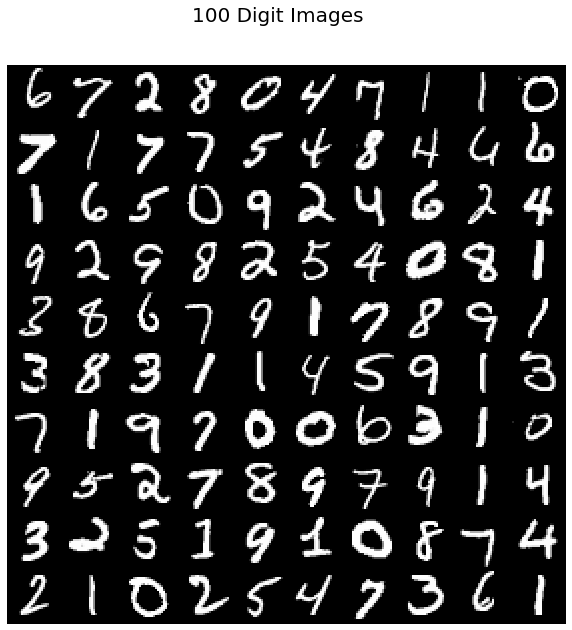

In [6]:
# Set Size of Plot in inches (note that the rendered version in iPython notebook will be smaller)
rcParams['figure.figsize'] = 10.0, 10.0

# Plot Digit Images
plot_mnist_images(train_X[sample(range(NB_TRAIN_CASES), NB_EXAMPLE_IMAGES)],
            title=str(NB_EXAMPLE_IMAGES) + ' Digit Images', fontsize=20)

### Create New Neural Network

In [7]:
# Create Feed-Forward Neural Network (FFNN)
# (doc: http://keras.io/models/#sequential)
printflush('\nCreating Feed-Forward Neural Network (FFNN)... ', end='')

ffnn = Sequential()

ffnn.add(Dense(
    input_dim=NB_DIGIT_IMAGE_PIXELS,
    output_dim=NB_NEURAL_NETWORK_HIDDEN_UNITS,
    init='uniform'))

ffnn.add(Activation('tanh'))

ffnn.add(Dense(
    input_dim=NB_NEURAL_NETWORK_HIDDEN_UNITS,
    output_dim=NB_DIGITS,
    init='uniform'))

ffnn.add(Activation('softmax'))

printflush('done!\n')


Creating Feed-Forward Neural Network (FFNN)... done!



### Set Neural Network Loss Function & Optimization Procedure

In [8]:
printflush('\nCompiling FFNN with Objective Loss Function & Optimization Method... ', end='')

rms_prop_optimizer = RMSprop()
#stochastic_gradient_descent_optimizer = SGD(
#    lr=SGD_OPTIMIZER_LEARNING_RATE,
#    decay=SGD_OPTIMIZER_LEARNING_RATE_DECAY_RATE,
#    momentum=SGD_OPTIMIZER_MOMENTUM_RATE,
#    nesterov=SGD_OPTIMIZER_NESTEROV_MOMENTUM_YESNO)

ffnn.compile(
    loss='categorical_crossentropy',
    optimizer=rms_prop_optimizer)

printflush('done!\n')


Compiling FFNN with Objective Loss Function & Optimization Method... done!



### Train Neural Network

In [9]:
# Initiate FFNN Training Monitor to keep track of training progress
ffnn_training_monitor = NeuralNetworkTrainingMonitor(
    reporting_freq=10,
    plot_title='Neural Network Learning Curves: MNIST Hand-Written Digits',
    bokeh_output='server')


# Train FFNN
ffnn.fit(
    X=train_X_matrix,
    y=train_y_binary_matrix,
    nb_epoch=NB_TRAIN_EPOCHS,
    batch_size=TRAIN_MINI_BATCH_SIZE,
    show_accuracy=True,
    validation_split=VALIDATION_DATA_PROPORTION,
    verbose=0,   # no need to log output to the terminal because we already have the live plot
    callbacks=[ffnn_training_monitor],
    shuffle=True)


# Obtain best trained FFNN
ffnn = ffnn_training_monitor.best_model


Connecting to Bokeh Server for live Learning Curves plotting...

Using saved session configuration for http://localhost:5006/
To override, pass 'load_from_config=False' to Session

Connecting to Bokeh Server for live Learning Curves plotting... done!


FFNN Training Progress
______________________


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100685). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100709). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108426). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113568). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113351). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118391). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125506). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123973). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134154). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131589). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149851). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136939). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139234). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158994). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157532). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156858). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.264223). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132131). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171920). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188646). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183457). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189336). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202651). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101350). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202978). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101510). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211359). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105697). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204939). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102493). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210726). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105390). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193627). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197944). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211985). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106017). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208538). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104288). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234942). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117492). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220529). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110290). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219936). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109987). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228939). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114490). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230009). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115025). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.260301). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130175). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238872). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119459). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242169). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121110). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239099). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119565). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.267689). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133865). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.282868). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141457). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.275045). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137546). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.264295). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132171). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.281405). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140726). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.264241). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132139). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.279247). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139648). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.273727). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136882). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)
/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.273510). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)



FFNN Training Finished! (14,399 Batches in total)

Best trained FFNN (with lowest Validation Loss) is from epoch #189
Training Accuracy (approx) = 99.4%, Validation Accuracy = 97.6%



/Applications/anaconda/lib/python2.7/site-packages/keras/callbacks.py:58: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136773). Check your callbacks.
  'to the batch update (%f). Check your callbacks.' % delta_t_median)


### Evaluate Test-Set Prediction Accuracy


Evaluating Trained FFNN on Test Data...
Test Set Accuracy = 97.87%

Incorrectly Classified Test Predicted Labels:
[[5 2 7 7 0 9 5 0 2 3 3 8 6 3 4 7]
 [8 7 9 7 7 5 2 0 5 8 6 0 5 4 4 2]
 [2 5 9 5 7 3 1 2 6 3 7 0 3 9 5 7]
 [6 3 8 3 6 3 7 3 0 2 2 7 9 3 4 2]
 [5 7 2 4 2 0 9 1 8 3 8 0 0 0 5 8]
 [8 1 4 4 0 1 3 0 8 2 7 8 1 7 2 4]
 [9 0 1 4 2 0 0 5 3 6 8 7 1 4 0 6]
 [3 3 2 3 4 8 0 3 2 7 9 2 3 7 1 3]
 [7 7 3 9 7 1 9 5 8 4 3 5 9 7 3 4]
 [2 9 7 8 2 9 3 6 2 5 3 2 7 0 7 3]
 [8 8 9 9 3 2 2 6 0 9 7 9 3 7 4 5]
 [5 7 6 3 8 2 0 8 8 9 2 6 6 2 2 2]
 [2 5 3 8 3 4 8 7 3 7 5 0 6 0 5 9]
 [8 7 8 8 3 '' '' '' '' '' '' '' '' '' '' '']]
Showing Incorrectly Classified Test Images...
If your model is well-trained, these images should be pretty hard to decide


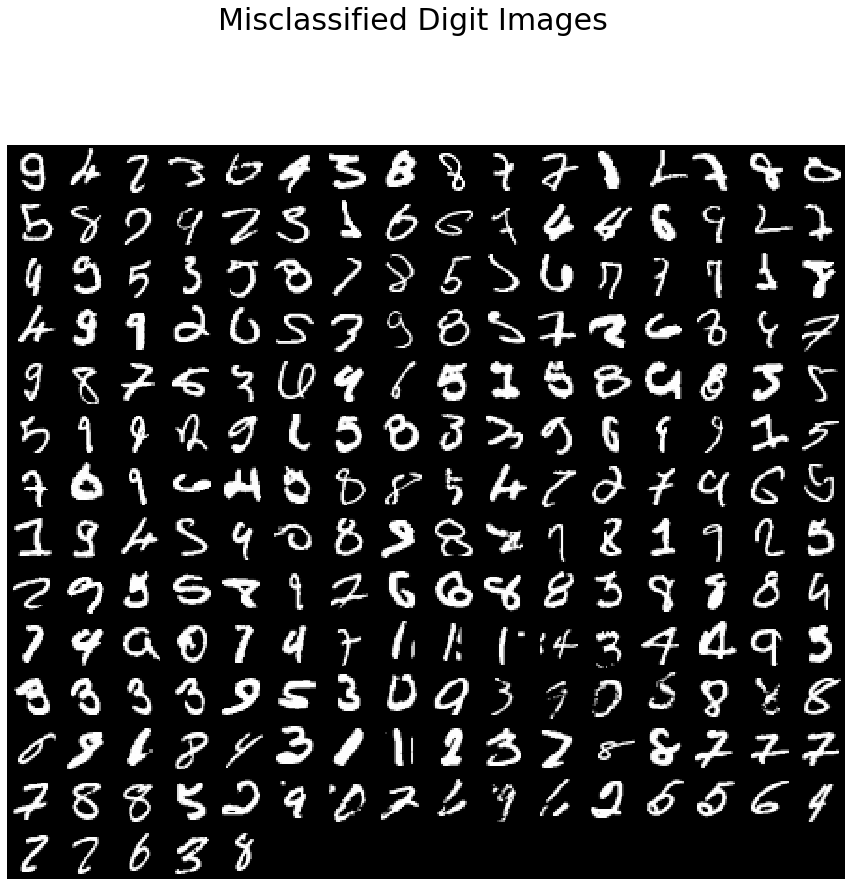

In [10]:
printflush('\nEvaluating Trained FFNN on Test Data...')
predicted_test_labels = ffnn.predict_classes(X=test_X_matrix, verbose=0)
correctly_classified_test_cases = predicted_test_labels == test_y
printflush('Test Set Accuracy = %s%%' % '{:.2f}'.format(100. * sum(correctly_classified_test_cases) / NB_TEST_CASES))

incorrectly_classified_test_indices = array(range(NB_TEST_CASES))[correctly_classified_test_cases == False]
incorrectly_classified_test_predicted_labels = predicted_test_labels[incorrectly_classified_test_indices]
incorrectly_classified_test_images = test_X[incorrectly_classified_test_indices]

printflush('\nIncorrectly Classified Test Predicted Labels:')
# Set Size of Plot in inches (note that the rendered version in iPython notebook will be smaller)
rcParams['figure.figsize'] = 15.0, 15.0
# Plot Mis-classified Digit Images
print_digit_labels(incorrectly_classified_test_predicted_labels)

printflush('Showing Incorrectly Classified Test Images...')
printflush('If your model is well-trained, these images should be pretty hard to decide')
plot_mnist_images(incorrectly_classified_test_images, title='Misclassified Digit Images', fontsize=30)

### Analyzing Features detected by Neural Network

Let's now make some plots to see what features the Neural Network has detected in the process of classifying the MNIST images. We can vizualize the weights between the first and second network layer:

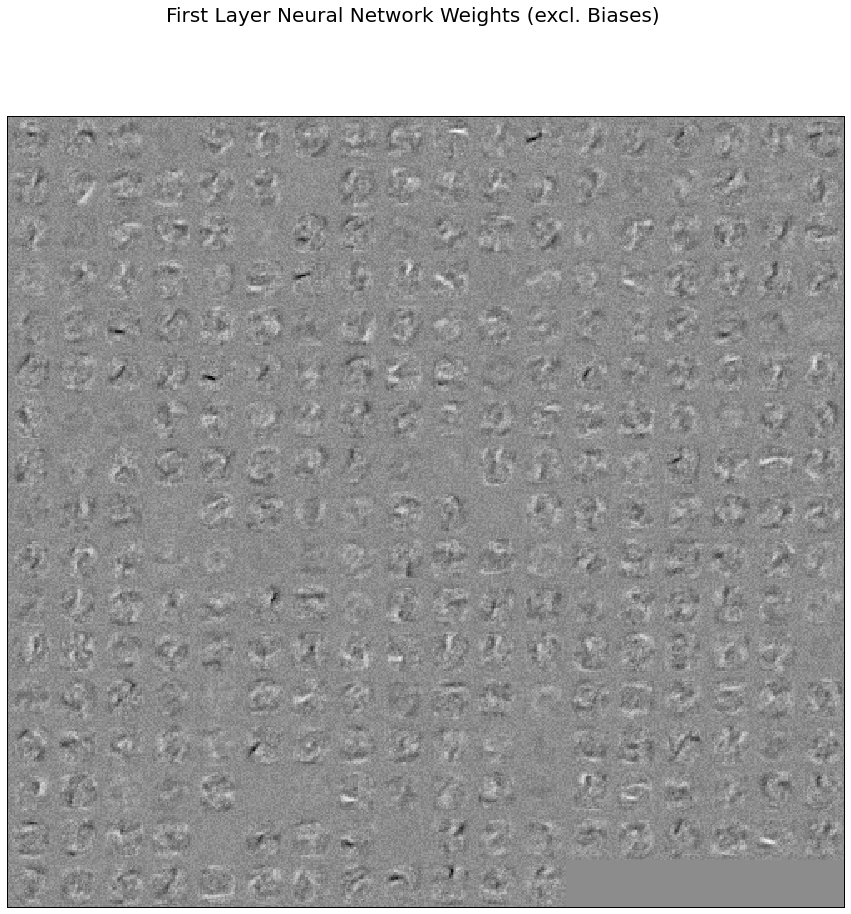

In [11]:
first_layer_weights = ffnn.layers[0].get_weights()[0].T.reshape(
    [NB_NEURAL_NETWORK_HIDDEN_UNITS,
     DIGIT_IMAGE_DIMENSION,
     DIGIT_IMAGE_DIMENSION])

rcParams['figure.figsize'] = 15.0, 15.0
plot_mnist_images(
    first_layer_weights,
    title='First Layer Neural Network Weights (excl. Biases)',
    fontsize=20)

From the visualization of the weights above, it seems that the hidden neurons have specialized themselves in detecting **useful local features** such as **strokes** and **hooks** that are present or missing in various types of digit images.